# Example: MeanVariance MPC Framework

In this example we will be using the **Static Market** model as well as the **Discrete Event Driven Simulation** (DEDS) egine.

The main idea behind **MPC** (Model Predictive Control) is the minimization/maximization of an objective function given a prediction of the behaviour of a system given an initial state, inputs and constraints. The objective function usually provides a trade-off between expected returns and risks one expects in the future given a plan.

The following assumptions for backtesting will be made:
1. The value of the asset can be approximated to its closing value at the end of the day.
1. The value of each asset is independent from the amount of shares we buy and sale.


## Introduction to the MPC Strategy: Multi-period Portfolio Optimization

The MPC  formulation for this example is based from the paper published by Xiaoyue Li on 2022.[1] And a bried description of it will be presented here.

- **Multi-Period Mean-Variance:** This method tries to solve an QP problem were the cost functional has a negative quadratic term for each daily(transition) variance day and a positive linear term for returns.[1] By minimizing such cost functional a tradeoff between expected risk (variance) and expected returns is achieved, not in a ratio sense like optimizing sharpe but in opposing forces of a QP problem.  

> [1] Xiaoyue Li, A. Sinem Uysal, John M. Mulvey, 
> Multi-period portfolio optimization using model predictive control with mean-variance and risk parity frameworks,
> European Journal of Operational Research,
> Volume 299, Issue 3,
> 2022,
> Pages 1158-1176,
> ISSN 0377-2217,
> https://doi.org/10.1016/j.ejor.2021.10.002.
> (https://www.sciencedirect.com/science/article/pii/S037722172100847X)

### Formulation

$$
\max_{\pi_{t+1},...,\pi_{t+H}} \left(\sum_{\tau=t+1}^{\tau=t+H} \hat{r}^{T}_{\tau|t}\pi_{\tau} 
- \gamma^{risk}\left(\pi_{\tau}^T \hat{\Sigma}_{\tau|t}\pi_{\tau}\right) 
- \gamma^{trade}||\pi_{\tau}-\pi_{\tau-1}||_1
\right)
$$
Subject to:
$$
\pi_{\tau}\geq 0\quad \forall\tau=t+1,...,t+H
$$
$$
\textbf{1}^T\pi_{\tau}=1 \quad \forall\tau=t+1,...,t+H
$$


Where
$$\hat{r}_{\tau|t}:\text{Estimation of the expected return vector at time }\tau \text{ given time up to  t} $$
$$\hat{\Sigma}_{\tau|t}:\text{Estimation of the covariance matrix at time } \tau \text{ given time up to  t}$$
$$\pi_{t+i}:\text{Distribution of portfolio value (across assets) on time }t+i $$
$$\gamma^{risk}:\text{Risk aversion parameter}$$
$$\gamma^{trade}:\text{Transaction cost}$$

### Forecasting
As in the previous discussion this methods also use forecasting  to obtain the estatistical estimates of the future days. However the statistical properties such as the return vector and the covariance matrix are estimated through the tuning of Hidden Markov Models **HMM** looking through 2000 days into the past.

The reason of the long horizon is to be able to capture cyclical behaviours  and fit the model accordingly, this seasonal behaviours are known as regimes. The paper [1] claims that **HMM** could be used to descrieb a regime switching behaviours, and that no more than 2 regimes are necessary to capture real market behaviour.

A thorougher example on forecasting performance and different method, along with their merits, formulations and performance comparisons can be found in a separate notebook ["MPC Additional Resources: Forecasting"]()



## Julia setup

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(["Dates","Plots","DataFrames", "DirectSearch","DotMaps","LinearAlgebra","Polynomials","SparseArrays","MathOptInterface"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Suppressor ─ v0.2.4
    Updating `~/.julia/environments/v1.8/Project.toml`
  [fd094767] + Suppressor v0.2.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [fd094767] + Suppressor v0.2.4
Precompiling project...
  ✓ Suppressor
  1 dependency successfully precompiled in 9 seconds. 216 already precompiled.


### Generation of DataSet
This dataset is formed by the top 5 most traded companies according to NASDAQ on the date, listed since 2016 from Jan 1st 2017 until Jan 1st 2022.

In [2]:
using DataFrames: groupby, combine
########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)
@info "Done!"

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T10:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T10:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T10:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T10:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL


In [2]:
# If you already have the data somewhere accessible by the cache loading the data directly is faster
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
data=load_bundle(bundle_id;cache_dir=cache_dir)
using AirBorne.ETL.AssetValuation: stockValuation, returns
dollar_symbol = "FEX/USD"
sv=stockValuation(data)
sv[!,dollar_symbol].=1.0
sr=returns(sv)
@info "DataGenerated"

[ Info: DataGenerated


## Simulation using AirBorne's MPC Strategy template 
In the next sections the MPC Strategy template will be used under different forecasting methods and configurations.


### Case 1: Perfect Forecasting

The first case to be analysed is the perfect forecasting, meaning that there is a method that is able to predict with 100% accuracy the dollar value which assets are to be traded the objective is to determine a benchamark for the MPC Strategy using different forecasting methods to be measured against.


This example has no notion of variance so the cost functional will be missing the variance minimization term. 
$$
\max_{\pi_{t+1},...,\pi_{t+H}} \left(\sum_{\tau=t+1}^{\tau=t+H} \hat{r}^{T}_{\tau|t}\pi_{\tau} 
- \gamma^{trade}||\pi_{\tau}-\pi_{\tau-1}||_1
\right)
$$
Which is equivalent to let the covariance matrix or its associated factor to 0.

In [ ]:
using AirBorne.Engines.DEDS: run
using AirBorne.ETL.AssetValuation: stockValuation, returns
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Strategies.MeanVarianceMPC: predeterminedReturns
using AirBorne.Structures: ContextTypeA, TimeEvent, summarizePerformance
import AirBorne.Strategies.MeanVarianceMPC as mpc
using Dates: DateTime

# Define Perfect Forecasting Function
dollar_symbol = "FEX/USD"
sv=stockValuation(data)
sv[!,dollar_symbol].=1.0
sr=returns(sv)
forecastFun(context) = predeterminedReturns(context, sr)

# Evaluation events
evaluationEvents = [TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)]

parameters = Dict("horizon" => 7)
otherExtras = Dict("symbolOrder" => collect(unique(data.assetID)))


### Agent Operations
template_perfect_initialize!(context) = mpc.initialize!(
            context;
            currency_symbol=dollar_symbol,
            min_data_samples=5,
            otherExtras=otherExtras,
            parameters=parameters)

template_perfect_trading_logic!(context, data) = mpc.tradingLogic!(context, data; forecastFun=forecastFun)

### Market Operations
# In this strategy we want to reflect the money in our accounts in the portfolio composition
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true)
my_expose_data(context,data) = expose_data(context,data; historical=false)

@time mpc_context = run(
        data,
        template_perfect_initialize!,
        template_perfect_trading_logic!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        # max_iter=7,
        verbose=true,
        initialEvents=evaluationEvents,
    )

@info "done"

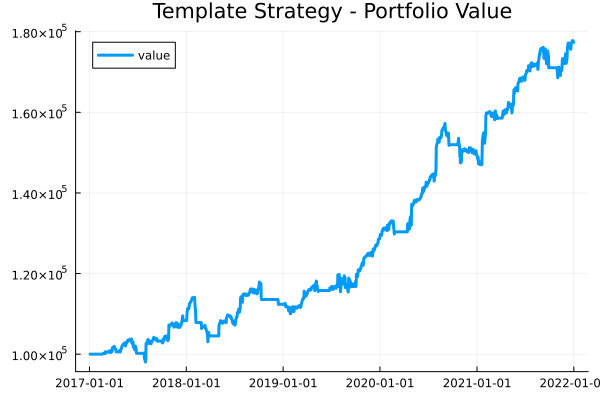

In [5]:
using AirBorne.Structures: summarizePerformance
using Plots: plot
results = summarizePerformance(data, context)
plot(results.date, results.dollarValue, title="Template Strategy - Portfolio Value", label="value", linewidth=3)

[ Info: DataGenerated


In [3]:
using AirBorne.Utils: δ,rvcat,rblockdiag
δ(0,1)

0

In [4]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

r1 = [3,1];r2 = [1,5]
n_assets = 2 # Number of assets
T = 2 # Horizon
nT = n_assets*T # Number of control variables
B1=kron(sparse(I, T, T),ones(1,n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

model = Model(Ipopt.Optimizer);set_silent(model)
𝛾_trade = 1
r = vcat(r1,r2)' # Return vector
@variable(model, x[1:nT] >= 0)
@variable(model, sum_portfolio_differences)
@constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
@objective(model, Min, -r*x + 𝛾_trade*sum_portfolio_differences) # Without variance minimization
@constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
optimize!(model)
value.(x)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



4-element Vector{Float64}:
  0.31654264890670786
  0.6834573510932922
 -8.74044883018228e-9
  1.0000000087404488

## Case 2: Mean-Variance forecast minimization

In [265]:

𝛾_risk = 0.7
v1 = reshape([1,2,3,4],n_assets,n_assets)
v2 = reshape([6,3,2,4],n_assets,n_assets)
Q = rblockdiag([v1,v2])

model = Model(Ipopt.Optimizer);set_silent(model)
@variable(model, x[1:nT] >= 0)
@variable(model, sum_portfolio_differences)
@constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
@objective(model, Min, -r*x + 𝛾_trade*sum_portfolio_differences + 𝛾_risk*(x'*Q*x)) # With variance minimization
@constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
optimize!(model)
value.(x)

4-element Vector{Float64}:
  1.0000000083245364
 -8.32453649864602e-9
  0.10000000243522092
  0.8999999975647791

# Visualization Examples

### Writing your own parser
A parser translates your control formulation into actionable orders to pass to the market. Is a critical part of any controller that aims to generate orders for trading. In this example our control variable is the proportion of the value of our portfolio allocated into each asset. The parser picks our current portfolio, the selected desired portfolio and the value of each asset and produces the set of orders that achieves the target distribution whilst incurring minimal fees.

In [4]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

using DataFrames: DataFrame
using AirBorne.Structures: ContextTypeA
using DotMaps: DotMap
using AirBorne.Markets.StaticMarket: Order

"""
    my_genOrder(assetId::Union{String,Symbol},amount::Real; account::Any=nothing,orderType::String="MarketOrder")
    
    Shortcut to generate market orders, in it the assetId is defined by "ExchangeID/TickerSymol", 
    amount is a real number with the number of shares to be purchased, account is the account to be used to
    provide the money for the transaction and order type is the type of the order. 
"""
function my_genOrder(
    assetId::Union{String,Symbol},
    amount::Real;
    account::Any=nothing,
    orderType::String="MarketOrder",
)
    market, ticker = split(String(assetId), "/")
    order_specs = DotMap(Dict())
    order_specs.ticker = String(ticker)
    order_specs.shares = amount # Number of shares to buy/sell
    order_specs.type = orderType
    if !(isnothing(account))
        order_specs.account = account
    end
    return Order(String(market), order_specs)
end

"""
    ordersForPortfolioRedistribution(
        sourcePortfolio::Dict{String, Float64}, 
        targetDistribution::Dict{String, Float64},
        assetPricing::Dict{String, Float64};
        curency_symbol::String= "FEX/USD", 
        account::Any=nothing,
        costPropFactor::Real=0,
        costPerTransactionFactor::Real=0,
        )
    This function generates the orders to obtain a particular value distribution on a given portfolio and static pricing.
    It can consider proportional costs by scaling the orders amount by a factor and a fixed cost for each transacted asset.
    It returns the portfolio with the desired distribution and the maximum amount of value expressed in a particular currency.

    -`sourcePortfolio::Dict{String, Float64}`: Dictionary with assets and how many units of them are present in a portfolio 
    -`targetDistribution::Dict{String, Float64}`: Desired distribution of the total value of the portfolio across the whole shares. The values do not need to add to 1, linear scaling will be used.
    -`assetPricing::Dict{String, Float64}`: Value of each share of an asset, with a corresponding value expressed in terms of a currency.
    -`curency_symbol::String= "FEX/USD"`: Symbol used to represent the currency in which the transactions are goint to take place. By default dollars, it should have value 1 on the assetPricing dictionary.
    -`account::Any=nothing`: Argument to be passed to the account field in the orders.
    -`costPropFactor::Real=0`:  Fee rate applied to the sell or purchase of any asset proportional to the value of the transaction.
    -`costPerTransactionFactor::Real=0`: Fee per transaction, every time an asset is sold/bought this fill will apply.
    -`min_shares_threshold::Real=10^-5`: Minimum amount of shares needed to trigger an order generation.
"""
function my_ordersForPortfolioRedistribution(
    sourcePortfolio::Dict{String,Float64},
    targetDistribution::Dict{String,Float64},
    assetPricing::Dict{String,Float64};
    curency_symbol::String="FEX/USD",
    account::Any=nothing,
    costPropFactor::Real=0,
    costPerTransactionFactor::Real=0,
    min_shares_threshold::Real=10^-5
)
    # Generate Source Distribution from Portfolio
    totalValue = sum([sourcePortfolio[x] * assetPricing[x] for x in keys(sourcePortfolio)])
    sourceDst = Dict([
        x => sourcePortfolio[x] * assetPricing[x] / totalValue for
        x in keys(sourcePortfolio)
    ])

    assetSort = [x for x in keys(sourceDst)]
    N = length(assetSort)
    curency_pos = findall(x -> x == curency_symbol, assetSort)[1]
    ShareVals = [assetPricing[x] for x in assetSort]
    propShareVal = ShareVals ./ totalValue # Share Price expressed in terms of portfolio units.

    # Problem Vectorization: D1 + P*d - Fees -> D2*k
    D1 = [get(sourceDst, x, 0) for x in assetSort] # Source
    D2 = [get(targetDistribution, x, 0) for x in assetSort] # Objective
    M = zeros(N, N)
    M[curency_pos, :] = propShareVal .* -1 # Price to pay per share (without fees)
    P = spdiagm(0 => propShareVal) + M
    FDollars = SparseVector(N, [curency_pos], [1]) # Dollar Fees Vector

    #####
    ##### Optimization Problem
    #####
    genOrderModel = Model(Ipopt.Optimizer)
    set_silent(genOrderModel)
    @variable(genOrderModel, 0 <= k) # Proportionality factor (shrinkage of portfolio)
    @variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
    @variable(genOrderModel, propFees >= 0) # Amount Proportional Fees
    @constraint(
        genOrderModel,
        [propFees; (propShareVal .* d) .* costPropFactor] in MOI.NormOneCone(1 + N)
    ) # Implementation of norm-1 for Fees
    @variable(genOrderModel, perTransactionFixFees >= 0) # Number of transactions fees
    @constraint(
        genOrderModel, perTransactionFixFees == sum(-δ.(d) .+ 1) * costPerTransactionFactor
    ) # Implementation of norm-1 for Fees
    @constraint(genOrderModel, d[curency_pos] == 0) # Do not buy or sell dollars (this is the currency).
    @constraint(
        genOrderModel,
        D1 .+ (P * d) .- (FDollars .* (propFees + perTransactionFixFees)) .== D2 .* k
    ) # Distribution ratio
    @objective(genOrderModel, Max, k) # With variance minimization
    optimize!(genOrderModel)
    d = value.(d)

    #### 
    #### Parsing & Order Generation
    ####
    n_shares = Dict([assetSort[x] => d[x] for x in 1:N if (x != curency_pos) && (abs(d[x])>min_shares_threshold)])
    orders = [my_genOrder(x, n_shares[x]; account=account) for x in keys(n_shares)]
    return orders
end


my_ordersForPortfolioRedistribution

### Writing your Forecasting function

The NPC controller will make a decision on the optimal portfolio distribution over time as to maximize the total return over a horizon. However in order to do that a forecast to predict how the returns of each asset will behave in the future is needed.

In [23]:
# This function returns the forecast of the returns

using AirBorne.Structures: ContextTypeA, TimeEvent
using Dates:DateTime
using DataFrames: DataFrame
using DotMaps: DotMap
# The forecasting functions need to receive nothing more than the context. The trading logic and initialization functions need to ensure that the context has enough
# information to be compatible with the forecasting function
" Returns a sequence of tuples with (returnVector,CovarianceMatrix)"
function perfectForecastReturns(context::ContextTypeA,returnData::DataFrame)
    n_assets = length(context.extra.symbolOrder)
    horizon=context.parameters.horizon
    r_mat=float.(Matrix(first(sr[sr.date.>context.current_event.date,context.extra.symbolOrder],horizon)))
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end



function linearRegressionForecast(context::ContextTypeA)# TODO. Actually create function
    n_assets = length(context.extra.symbolOrder)
    horizon=context.parameters.ForecastHorizon
    data=context.extra.returnHistoryData
    r_mat= zeros(horizon,n_assets)
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end

# linearRegressionForecast

# context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))
# symbolOrder = [name for name in names(sr) if occursin("/",name)]
# context.extra.dollar_symbol = "FEX/USD"
# context.extra.symbolOrder = symbolOrder
# context.parameters.ForecastHorizon=14
# forecastFun(context) = perfectForecastReturns(context,sr)
# forecast = forecastFun(context)
# # collect(vcat([x[:,1] for x in forecast]))
# r = reduce(vcat, [x[1] for x in forecast])
# initialCapital=10^5
# [setindex!(context.portfolio,0.0,n) for n in context.extra.symbolOrder]

# # y= Ref(a
# context.accounts.usd = DotMap(Dict())
# context.accounts.usd.balance = initialCapital
# context.accounts.usd.currency = context.extra.dollar_symbol 
# context.accounts.usd
# setindex!(context.portfolio,context.accounts.usd.balance,context.extra.dollar_symbol ) 
    
# setindex!(context.portfolio,Ref!(context.accounts.usd.balance),context.extra.dollar_symbol ) 
# Ref(context.portfolio[context.extra.dollar_symbol], context.accounts.usd.balance)
# context.portfolio[context.extra.dollar_symbol] = Ref( context.accounts.usd.balance)
# @info context.accounts.usd.balance
# @info context.portfolio[context.extra.dollar_symbol]
# context.accounts.usd.balance-=10^4
# @info context.accounts.usd.balance
# @info context.portfolio[context.extra.dollar_symbol]

linearRegressionForecast (generic function with 1 method)

### Writing your own MPC Strategy

In [54]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

using AirBorne.Markets.StaticMarket: place_order!

function my_initializeMPC!(context::ContextTypeA; 
        min_data_samples::Int64=200,
        currency_symbol::String = "FEX/USD",
        initialCapital::Float64=10.0^5,
        parameters::Dict=Dict(),
        otherExtras::Dict=Dict(),
    )
    
    # Internal Data Storage
    context.extra.returnsHistory=DataFrame()
    
    # Fixed attributes & parameters
    context.extra.min_data_samples=min_data_samples
    context.extra.currency_symbol = currency_symbol
    
    context.extra.valueHistory = DataFrame()
    context.extra.returnHistory = DataFrame()
    context.extra.currentValue = DataFrame()
    context.extra.pastValue = DataFrame()
    
    [setindex!(context.extra,otherExtras[key],key) for key in keys(otherExtras)]
    
    # Initialize Accounts     
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = currency_symbol
    
    # Initialize Portfolio
    if :symbolOrder in keys(context.extra)
        push!(context.extra.symbolOrder,currency_symbol)
        [setindex!(context.portfolio,0.0,n) for n in context.extra.symbolOrder] # Initialize an empty portfolio
    end
    context.portfolio[currency_symbol] = initialCapital # Sync portfolio with account at first
    
    # Adjustable hyper-parameters by StrategyOptimization
    [setindex!(context.parameters,parameters[key],key) for key in keys(parameters)]
    
    return nothing
end


function my_tradingLogicMPC!(context,data;forecastFun::Function=linearRegressionForecast)
    
    #######################
    ####  Update data  ####
    #######################
    if size(data,1)==0 # No New data, nothing to do
        return nothing 
    end
    context.extra.pastValue = context.extra.currentValue
    
    context.extra.currentValue=stockValuation(data)
    context.extra.currentValue[!,context.extra.currency_symbol] .= 1.0 # Add currency to values
    
    [push!(context.extra.valueHistory,r) for r=eachrow(context.extra.currentValue)]
    
    if size(context.extra.pastValue,1)>0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue,context.extra.currentValue))
        push!(context.extra.returnHistory,r1[end,:])
    end

    ###############
    ####  MPC  ####
    ###############

    if size(context.extra.returnHistory,1)<context.extra.min_data_samples
        return nothing # Not enough history data to continue
    end
    
    # Forecasts
    meanVarianceForecast = forecastFun(context) # Returns a sequence of Return vectors and Covariance matrices

    # Matrices Definitions
    r = rvcat([rV[1] for rV in meanVarianceForecast]) # Return Vector
    Q = rblockdiag([rV[2] for rV in meanVarianceForecast]) # Block diagonal with covariance matrices in the diagonal
    𝛾_trade = get(context.parameters,"propCost",0.05)
    𝛾_risk = get(context.parameters,"riskWeight",0.0)
    n_assets = length(context.extra.symbolOrder)
    T = context.parameters.horizon
    B1=kron(sparse(I, T, T),ones(1,n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

    # Optimization Problem
    model = Model(Ipopt.Optimizer);set_silent(model)
    @variable(model, x[1:length(r)] >= 0)
    @variable(model, sum_portfolio_differences)
    @constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
    @objective(model, Min, -r'*x + 𝛾_trade*sum_portfolio_differences + 𝛾_risk*(x'*Q*x)) # With variance minimization
    @constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
    optimize!(model)
    sol=round.(value.(x)[1:n_assets];digits=3) # Best next portfolio distribution
    
    # Decode solution into buy/sell orders
    assetPricing = context.extra.currentValue[1,"stockValue"] 
    assetPricing[context.extra.currency_symbol] = 1.0
    orders = ordersForPortfolioRedistribution(
        convert(Dict{String,Float64},context.portfolio),
        Dict([context.extra.symbolOrder[i]=>sol[i] for i=1:n_assets]),
        assetPricing;
        account=context.accounts.usd,
        curency_symbol= context.extra.currency_symbol,
        costPropFactor=𝛾_trade
    )
    [place_order!(context,order) for order in orders] # Place orders
    return nothing
end

my_tradingLogicMPC! (generic function with 1 method)

### Run Simulation with custom Strategy

In [55]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using AirBorne.Structures: summarizePerformance
using Dates: DateTime

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]

parameters=Dict("horizon"=>14)
otherExtras=Dict(
    "symbolOrder"=>collect(unique(data.assetID))
)

# Test Initialization Function
context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))
custom_initialize!(context) = my_initializeMPC!(context;otherExtras=otherExtras, parameters=parameters)
# custom_initialize!(context)
forecastFun(context) = perfectForecastReturns(context,sr)
custom_trading_logic!(context,data) = my_tradingLogicMPC!(context,data;forecastFun=forecastFun)
# :symbolOrder in keys(context.extra)


my_expose_data(context,data) = expose_data(context,data; historical=false)
my_execute_orders!(context,data) = execute_orders!(context,data;propagateBalanceToPortfolio=true)
context.portfolio
    # context.extra.symbolOrder=symbolOrder
@time custom_context = run(
    data,
    custom_initialize!,
    custom_trading_logic!,
    my_execute_orders!,
    my_expose_data;
    audit=true,
    # max_date=DateTime(2022, 1, 1),
    max_iter=202,
    verbose=true,
    initialEvents=evaluationEvents,
)
@info "done"

 14.655630 seconds (14.59 M allocations: 969.627 MiB, 2.13% gc time, 32.52% compilation time: 25% of which was recompilation)


[ Info: done


In [56]:
context = custom_context
context.portfolio
# context.extra.valueHistory
# seq_data = Matrix(context.extra.returnHistory[!,context.extra.symbolOrder])
# meanVarianceForecast = forecastFun(context)

# # nT = 
# r = rvcat([rV[1] for rV in meanVarianceForecast]) # Return Vector
# Q = rblockdiag([rV[2] for rV in meanVarianceForecast]) # Block diagonal with covariance matrices in the diagonal
# 𝛾_trade = get(context.parameters,"propCost",0.05)
# 𝛾_risk = get(context.parameters,"riskWeight",0.0)
# n_assets = length(context.extra.symbolOrder)
# T = context.parameters.horizon
# B1=kron(sparse(I, T, T),ones(1,n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

# model = Model(Ipopt.Optimizer);set_silent(model)
# @variable(model, x[1:length(r)] >= 0)
# @variable(model, sum_portfolio_differences)
# @constraint(model, [sum_portfolio_differences; x[1:end-n_assets]-x[n_assets+1:end]] in MOI.NormOneCone(1 + length(x)-n_assets)) # Implementation of norm-1
# @objective(model, Min, -r'*x + 𝛾_trade*sum_portfolio_differences + 𝛾_risk*(x'*Q*x)) # With variance minimization
# @constraint(model, B1*x.-ones(T,1).==0 ) # Sum of portfolio distribution equals 1 for all days
# optimize!(model)
# sol=round.(value.(x)[1:n_assets];digits=3) # Best next portfolio distribution
# target_dist = Dict([context.extra.symbolOrder[i]=>sol[i] for i=1:n_assets])
# assetPricing = context.extra.currentValue[1,"stockValue"] 
# assetPricing[context.extra.currency_symbol] = 1.0
# orders = ordersForPortfolioRedistribution(
#     convert(Dict{String,Float64},context.portfolio),
#     target_dist,
#     assetPricing;
#     curency_symbol= context.extra.currency_symbol,
#     costPropFactor=𝛾_trade
# )



Dict{Any, Any} with 66 entries:
  "NCM/TTOO" => 0.0
  "NMS/CLNE" => 0.0
  "NYQ/KMI"  => 0.0
  "NYQ/CFG"  => 0.0
  "NCM/NEXT" => 0.0
  "NYQ/CCJ"  => 0.0
  "NYQ/CCL"  => 0.0
  "NMS/CSIQ" => 0.0
  "NMS/DISH" => 0.0
  "NYQ/DVN"  => 0.0
  "NYQ/JNPR" => 0.0
  "NYQ/RIO"  => 0.0
  "NMS/GILD" => 0.0
  "NYQ/CNHI" => 0.0
  "NYQ/SYF"  => 0.0
  "NYQ/CIEN" => 0.0
  "NYQ/DAR"  => 0.0
  "NYQ/ABEV" => 0.0
  "NYQ/NVTA" => 0.0
  "NYQ/MAC"  => 0.0
  "NYQ/HPP"  => 0.0
  "FEX/USD"  => 366.243
  "NYQ/ABR"  => 0.0
  "NMS/AAPL" => 0.0
  "NMS/TSLA" => 0.0
  ⋮          => ⋮

Dict{String, Float64} with 66 entries:
  "NCM/AEHR" => 0.0
  "NMS/INFN" => 0.0
  "NCM/TTOO" => 0.0
  "NMS/CLNE" => 0.0
  "NMS/SFM"  => 0.0
  "NMS/ACAD" => 0.0
  "ASE/NG"   => 0.0
  "NYQ/KMI"  => 0.0
  "NYQ/CFG"  => 0.0
  "NCM/NEXT" => 0.0
  "NMS/JBLU" => 0.0
  "NMS/AMZN" => 0.0
  "NCM/WSC"  => 0.0
  "NMS/RUN"  => 0.0
  "NYQ/CF"   => 0.0
  "NYQ/CCJ"  => 0.0
  "NYQ/CCL"  => 0.0
  "NMS/CSIQ" => 0.0
  "NMS/DISH" => 0.0
  "NYQ/BABA" => 0.0
  "NYQ/AGI"  => 0.0
  "NMS/CSCO" => 0.0
  "NYQ/ENR"  => 0.0
  "NYQ/DVN"  => 0.0
  "NYQ/JNPR" => 0.0
  ⋮          => ⋮

In [49]:
using AirBorne.Markets.StaticMarket: ordersForPortfolioRedistribution
# context.portfolio

# Current Values. If I pick tomorrow values it should be a forecast of the opening values for tomorrow.


    

2-element Vector{Order}:
 Order("NCM", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "AEHR", :shares => 55.05093940479725)))
 Order("NYQ", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "SHOP", :shares => 9879.18585424884)))

In [137]:

trading_symbols = unique(data[!,"assetID"]); dollar_symbol="FEX/USD"
# Source
sourcePf = Dict([x=>0.0 for x in trading_symbols]); sourcePf[dollar_symbol] = 10^5;
# Target
# targetDst=Dict([x=>rand() for x in keys(sourcePf)]);normalization_factor=sum(values(targetDst))

targetDst=Dict([x=>0.0 for x in keys(sourcePf)]);
targetDst["NCM/AEHR"] = 0.1
targetDst["NCM/TTOO"] = 0.2
targetDst["NMS/CLNE"] = 0.05
targetDst["NMS/TSLA"] = 0.2
targetDst["NMS/AAPL"] = 0.05
targetDst["FEX/USD"]  = 0.4
normalization_factor=sum(values(targetDst))
targetDst=Dict([x=>targetDst[x]/normalization_factor for x in keys(targetDst)]) # Normalize

# Asset Value
assetPricing=sv[3,"stockValue"];assetPricing[dollar_symbol]=1.0;
ordersForPortfolioRedistribution(sourcePf,targetDst,assetPricing;curency_symbol=dollar_symbol,costPropFactor=0.03,costPerTransactionFactor=0)

[ Info: Dict("NCM/AEHR" => 0.1, "NMS/INFN" => 0.0, "NCM/TTOO" => 0.2, "NMS/CLNE" => 0.05, "NMS/SFM" => 0.0, "NMS/ACAD" => 0.0, "ASE/NG" => 0.0, "NMS/JBLU" => 0.0, "NYQ/CFG" => 0.0, "NYQ/KMI" => 0.0, "NCM/NEXT" => 0.0, "NMS/AMZN" => 0.0, "NCM/WSC" => 0.0, "NMS/RUN" => 0.0, "NYQ/CF" => 0.0, "NYQ/CCJ" => 0.0, "NYQ/CCL" => 0.0, "NMS/CSIQ" => 0.0, "NMS/DISH" => 0.0, "NYQ/BABA" => 0.0, "NYQ/AGI" => 0.0, "NMS/CSCO" => 0.0, "NYQ/ENR" => 0.0, "NYQ/DVN" => 0.0, "NYQ/JNPR" => 0.0, "NYQ/RIO" => 0.0, "NMS/GILD" => 0.0, "NYQ/CNHI" => 0.0, "NYQ/SYF" => 0.0, "NMS/MSFT" => 0.0, "NYQ/DLB" => 0.0, "NYQ/CIEN" => 0.0, "NYQ/DEI" => 0.0, "NYQ/DAR" => 0.0, "NYQ/ABEV" => 0.0, "NYQ/WRK" => 0.0, "NMS/KPTI" => 0.0, "NYQ/NVTA" => 0.0, "NYQ/MAC" => 0.0, "NYQ/HPP" => 0.0, "NYQ/BG" => 0.0, "NYQ/RYAM" => 0.0, "FEX/USD" => 0.4, "NYQ/ANET" => 0.0, "NYQ/ABR" => 0.0, "NMS/AAPL" => 0.05, "NMS/TSLA" => 0.2, "NYQ/MPW" => 0.0, "NMS/EXTR" => 0.0, "NYQ/BX" => 0.0, "NYQ/MET" => 0.0, "NMS/CALM" => 0.0, "NMS/NVDA" => 0.0, "NMS/EZP

5-element Vector{Order}:
 Order("NCM", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "AEHR", :shares => 4270.951449022448)))
 Order("NCM", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "TTOO", :shares => 75.70857902964775)))
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "AAPL", :shares => 168.47934272671264)))
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "TSLA", :shares => 1299.6500171731786)))
 Order("NMS", DotMap(Dict{Symbol, Any}(:type => "MarketOrder", :ticker => "CLNE", :shares => 1564.201879126462)))

In [120]:
using SparseArrays: SparseVector, spdiagm
trading_symbols = unique(data[!,"assetID"])
dollar_symbol="FEX/USD"
# Source
sourcePf = Dict([x=>0.0 for x in trading_symbols]);
sourcePf[dollar_symbol] = 10^5;@info typeof(sourcePf)
# Target
targetDst=Dict([x=>rand() for x in keys(sourcePf)]);
normalization_factor=sum(values(targetDst))
targetDst=Dict([x=>targetDst[x]/normalization_factor for x in keys(targetDst)]) # Normalize
@info typeof(targetDst)
# Asset Value
assetPricing=sv[3,"stockValue"];
assetPricing[dollar_symbol]=1.0;
@info typeof(assetPricing)


ordersForPortfolioRedistribution(sourcePf,targetDst,assetPricing;curency_symbol=dollar_symbol,costPropFactor=0.03,costPerTransactionFactor::Real=0)
    
"""
    ordersForPortfolioRedistribution(
        sourcePortfolio::Dict{String, Float64}, 
        targetDistribution::Dict{String, Float64},
        assetPricing::Dict{String, Float64};
        curency_symbol::String= "FEX/USD", 
        account::Any=nothing,
        costPropFactor::Real=0,
        costPerTransactionFactor::Real=0,
        )
    This function generates the orders to obtain a particular value distribution on a given portfolio and static pricing.
    It can consider proportional costs by scaling the orders by a (1-propCost) factor and a fixed cost for each transacted asset.
    It returns the portfolio with the desired distribution and the maximum amount of value expressed in a particular currency.

    -`sourcePortfolio::Dict{String, Float64}`: Dictionary with assets and how many units of them are present in a portfolio 
    -`targetDistribution::Dict{String, Float64}`: Desired distribution of the total value of the portfolio across the whole shares. The values do not need to add to 1, linear scaling will be used.
    -`assetPricing::Dict{String, Float64}`: Value of each share of an asset, with a corresponding value expressed in terms of a currency.
    -`curency_symbol::String= "FEX/USD"`: Symbol used to represent the currency in which the transactions are goint to take place. By default dollars, it should have value 1 on the assetPricing dictionary.
    -`account::Any=nothing`: Argument to be passed to the account field in the orders.
    -`costPropFactor::Real=0`:  Fee rate applied to the sell or purchase of any asset proportional to the value of the transaction.
    -`costPerTransactionFactor::Real=0`: Fee per transaction, every time an asset is sold/bought this fill will apply.
"""
function ordersForPortfolioRedistribution(
        sourcePortfolio::Dict{String, Float64}, 
        targetDistribution::Dict{String, Float64},
        assetPricing::Dict{String, Float64};
        curency_symbol::String= "FEX/USD", 
        account::Any=nothing,
        costPropFactor::Real=0,
        costPerTransactionFactor::Real=0,
        )
    # Generate Source Distribution from Portfolio
    totalValue = sum([sourcePortfolio[x]*assetPricing[x] for x in keys(sourcePortfolio)])
    sourceDst = Dict([x=>sourcePortfolio[x]*assetPricing[x]/totalValue for x in keys(sourcePortfolio)]) # 
    
    # 
    assetSort = [x for x in keys(sourceDst)]
    N = length(assetSort)
    curency_pos = findall( x -> x == curency_symbol, assetSort )[1]
    ShareVals = [assetPricing[x] for x in assetSort]
    propShareVal = ShareVals./totalValue # Share Price expessed in terms of portfolio units.
    
    # Problem Vectorization: D1 + P*d - Fees -> D2*k
    D1 = [get(sourceDst,x,0) for x in assetSort] # Source
    D2 = [get(targetDistribution,x,0) for x in assetSort] # Objective
    M=zeros(N,N); M[curency_pos,:] = propShareVal.*-1; # Price to pay per share (without fees)
    P = spdiagm(0=>propShareVal)+M;
    FDollars= SparseVector(N, [curency_pos], [1]) # Dollar Fees Vector
    
    #####
    ##### Optimization Problem
    #####
    genOrderModel = Model(Ipopt.Optimizer);set_silent(genOrderModel)
    @variable(genOrderModel,0<= k ) # Proportionality factor (shrinkage of portfolio)
    @variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
    @variable(genOrderModel, propFees >= 0) # Proportinal Fees
    @constraint(genOrderModel, [propFees; (propShareVal.*d).*costPropFactor] in MOI.NormOneCone(1 + N)) # Implementation of norm-1 for Fees
    @variable(genOrderModel, perTransactionFixFees >= 0) # Proportinal Fees
    @constraint(genOrderModel, perTransactionFixFees == sum(-δ.(d).+1)*costPerTransactionFactor) # Implementation of norm-1 for Fees
    @constraint(genOrderModel, d[curency_pos]==0 ) # Do not buy or sell dollars (this is the currency).
    @constraint(genOrderModel, D1 .+ (P*d) .- (FDollars.*(propFees + perTransactionFixFees)) .== D2.*k ) # Distribution ratio
    @objective(genOrderModel, Max, k) # With variance minimization
    optimize!(genOrderModel)
    d=value.(d)
    
    #### 
    #### Parsing & Order Generation
    ####
    amount = Dict([ assetSort[x]=>d[x] for x=1:N  if (x!=curency_pos)&&(d[x]!=0)])
    orders= [genOrder(x,amount[x];account=account) for x in keys(amount)]
    return orders
end


totalValue = sum([sourcePortfolio[x]*assetPricing[x] for x in keys(sourcePortfolio)])
sourceDst = Dict([x=>sourcePortfolio[x]*assetPricing[x]/totalValue for x in keys(sourcePortfolio)])
# @info sourceDst
# @info targetDistribution
assetSort = [x for x in keys(sourceDst)]
D1 = [get(sourceDst,x,0) for x in assetSort]
D2 = [get(targetDistribution,x,0) for x in assetSort]
ShareVals = [assetPricing[x] for x in assetSort]
@info "Done"

# usd/fex
dollar_pos = findall( x -> x == dollar_symbol, assetSort )[1]
N = length(assetSort)
propShareVal = ShareVals./totalValue # Share Price expessed in terms of portfolio units.
# @info spdiagm(0=>propShareVal)

M=zeros(N,N);
M[dollar_pos,:] = propShareVal.*-1;
# P = sparse(sparse(I,N,N)+M);
P = spdiagm(0=>propShareVal)+M;
# P[[dollar_pos],[dollar_pos]].=;
# v = sparse(zeros((length(assetSort),1)));
# v[dollar_pos]=1;
# v
# zeros((length(assetSort),1))
@info dollar_pos
FDollars= SparseVector(N, [dollar_pos], [1]) # Dollar Fees Vector

[ Info: Dict{String, Float64}
[ Info: Dict{String, Float64}
[ Info: Dict{String, Float64}
[ Info: Done
[ Info: 26


66-element SparseVector{Int64, Int64} with 1 stored entry:
  [26]  =  1

In [121]:
using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI

@info D1
@info D2
transactionFee=0.03
transactionCommission=0
# costFactor=0.03; # Implement a 3% commision for each sale/purchase
costFactor=0; # Implement a 3% commision for each sale/purchase
costPerTransactionFactor=0/totalValue; # Implement 50USD cost per transaction
# costPerTransactionFactor=50/totalValue; # Implement 50USD cost per transaction
# @variable(genOrderModel,0.9<= k ) # This is the magnitude of change of the overall portfolio
genOrderModel = Model(Ipopt.Optimizer);set_silent(genOrderModel)
@variable(genOrderModel,0<= k ) # Proportionality factor (shrinkage of portfolio)
@variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
@variable(genOrderModel, propFees >= 0) # Proportinal Fees
@constraint(genOrderModel, [propFees; (propShareVal.*d).*costFactor] in MOI.NormOneCone(1 + N)) # Implementation of norm-1 for Fees
@variable(genOrderModel, perTransactionFixFees >= 0) # Proportinal Fees
@constraint(genOrderModel, perTransactionFixFees == sum(-δ.(d).+1)*costPerTransactionFactor) # Implementation of norm-1 for Fees
@constraint(genOrderModel, d[dollar_pos]==0 ) # Do not buy or sell dollars (this is the currency).
@constraint(genOrderModel, D1 .+ (P*d) .- (FDollars.*(propFees + perTransactionFixFees)) .== D2.*k ) # Distribution ratio
@objective(genOrderModel, Max, k) # With variance minimization
optimize!(genOrderModel)
d=value.(d)

account=nothing
amount = Dict([ assetSort[x]=>d[x] for x=1:N  if (x!=dollar_pos)&&(d[x]!=0)])
orders= [genOrder(x,amount[x];account=account) for x in keys(amount)]

# @info amount
# @info orders
# @info "propFees: $(value.(propFees))"
# @info "d: $(value.(d))"
@info "k: $(value.(k))"


[ Info: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ Info: [0.00795180462965984, 0.02216696829870977, 0.0073490394958810115, 0.020902444657949323, 0.021841220008606027, 0.022024118822401156, 0.011481569715312943, 0.016508423064313934, 0.02193049086073564, 0.010529712779711913, 0.02400140637524488, 0.014261398649308712, 0.021020009675556225, 0.029262559156368027, 0.007672416544767523, 0.018574094341284257, 0.01516043503414009, 0.02332686509147741, 0.02896497502520406, 0.02668352575244129, 0.025623395211348987, 0.010406412702362736, 0.010548713377285041, 0.028734870713307215, 0.002678530445264297, 0.010150066525597896, 0.009247388524138441, 0.02225370292030708, 0.018081741292385958, 0.010706854060102232, 

In [104]:
δ(x,y) = (x==y ? 1 : 0)
δ(x) = (x==0 ? 1 : 0)
δ(0)
sum(-δ.([1,0,3,0]).+1)
# [2,3].*[4,5]

2

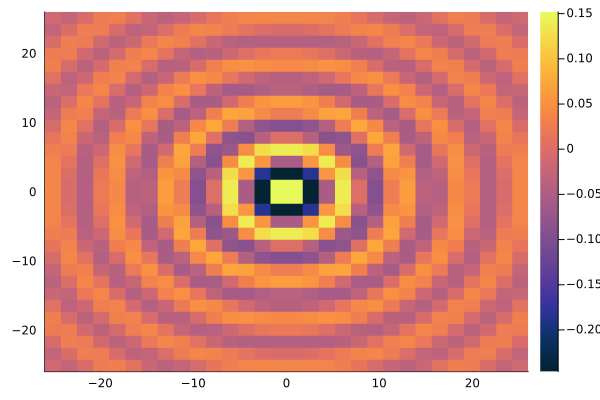

In [99]:
# Calling heatmap with a functiion
fdummy(x, y)= cos(sqrt(x^2 + y^2)) / (1 + sqrt(x^2 + y^2))
x = range(-8π, 8π, length = 30)
heatmap(x, x, fdummy, c = :thermal)

In [62]:
usdData=deepcopy(data[data.assetID.=="NCM/AEHR",:])
usdData[!,:assetID].="FEX/USD"
usdData[!,:exchangeName].="FEX"
usdData[!,:symbol].="USD"
usdData[!,[:close,:high,:low,:open]].=1.0
usdData[!,[:volume]].=0
vcat(data,usdData)


Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,2.38,2.4,2.25,2.34,25500,2017-01-03T10:30:00,1483453800,NCM,America/New_York,USD,AEHR,NCM/AEHR
2,2.32,2.38,2.24,2.34,23300,2017-01-04T10:30:00,1483540200,NCM,America/New_York,USD,AEHR,NCM/AEHR
3,2.3,2.63,2.24,2.35,64100,2017-01-05T10:30:00,1483626600,NCM,America/New_York,USD,AEHR,NCM/AEHR
4,2.34,2.37,2.3,2.3,47800,2017-01-06T10:30:00,1483713000,NCM,America/New_York,USD,AEHR,NCM/AEHR
5,2.37,2.45,2.32,2.32,7700,2017-01-09T10:30:00,1483972200,NCM,America/New_York,USD,AEHR,NCM/AEHR
6,2.37,2.42,2.35,2.35,18000,2017-01-10T10:30:00,1484058600,NCM,America/New_York,USD,AEHR,NCM/AEHR
7,2.46,2.47,2.37,2.37,16400,2017-01-11T10:30:00,1484145000,NCM,America/New_York,USD,AEHR,NCM/AEHR
8,2.48,2.52,2.48,2.48,3000,2017-01-12T10:30:00,1484231400,NCM,America/New_York,USD,AEHR,NCM/AEHR
9,2.52,2.59,2.45,2.45,10800,2017-01-13T10:30:00,1484317800,NCM,America/New_York,USD,AEHR,NCM/AEHR
